In [32]:
pip install nilearn

In [43]:
from nilearn.datasets import fetch_haxby
from nilearn.image import index_img
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map
import pandas as pd

# Fetch
data_files = fetch_haxby(subjects=[2])
func_filenames = data_files.func[0]

In [44]:

behavioral = pd.read_csv(data_files.session_target[0], sep=" ")
mask = behavioral['labels'].isin(['rest'])
behavioral = behavioral[~mask]


In [42]:
fmri_img = index_img(func_filenames , ~mask)
masker = NiftiMasker(mask_img=data_files['mask_vt'][0])
fmri_data = masker.fit_transform(fmri_img)

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


mean Response  for category : face
mean Response  for category : house
mean Response  for category : scissors
mean Response  for category : chair


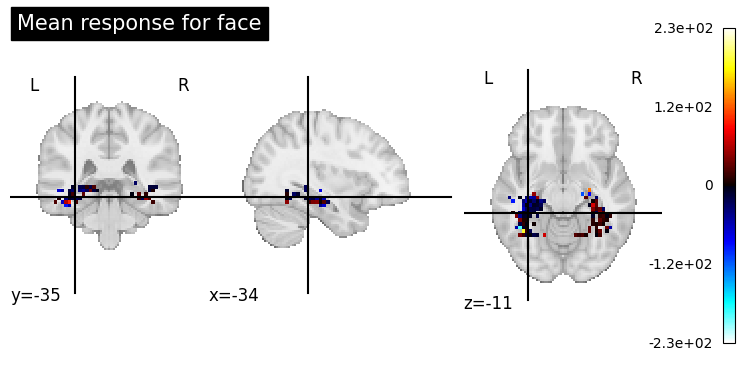

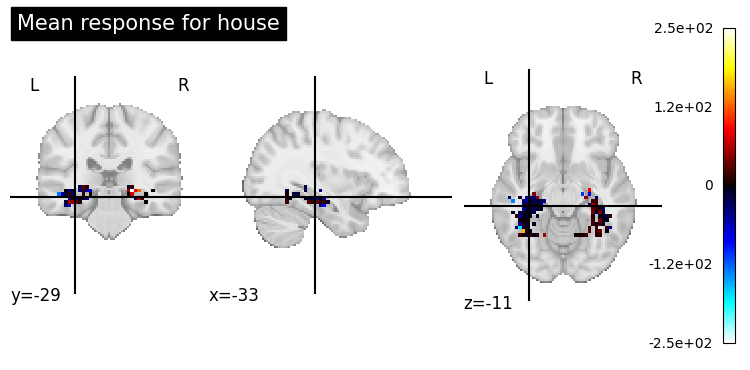

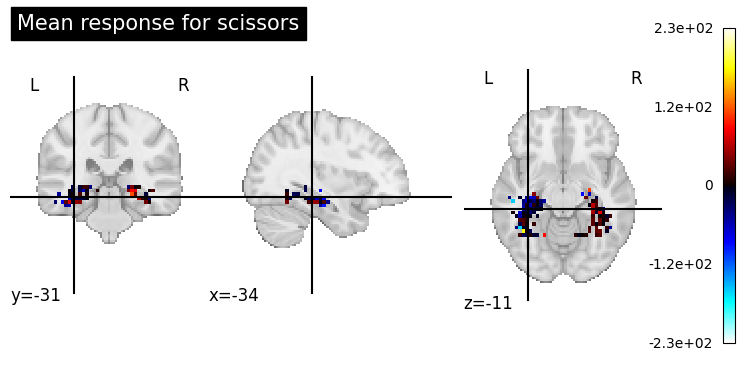

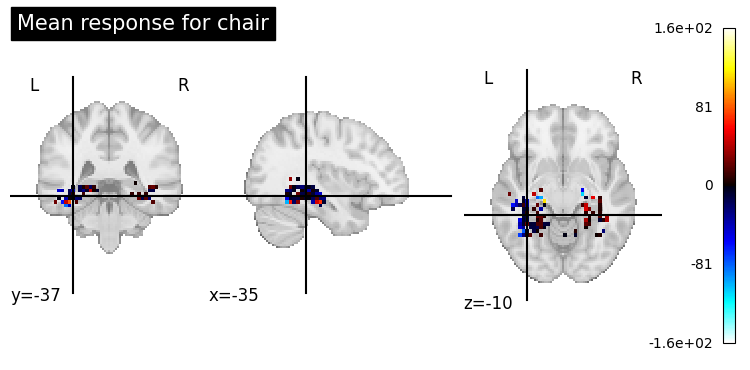

In [45]:
#  store categories
categories = []

categories.append('face')
categories.append('house')
categories.append('scissors')
categories.append('chair')



# total mean
tot_mean = fmri_data.mean(axis=0)

# Initialize a dictionary for storing mean removed fmri data for each category
mean_removed_fmri_dict = {}

# Loop
#for category
for category in categories:
    # Restrict behavioral target to specific category
    category_mask = behavioral['labels'].isin([category])
    cat_tgt_data = fmri_data[category_mask]

    # Remove grand mean or global mean computed across all categories removing 'rest'
    mean_removed_fmri_dict[category] = cat_tgt_data - tot_mean

     # Invert removed fmri data to first mean space
    inverted_mean_removed_fmri_img = masker.inverse_transform(mean_removed_fmri_dict[category])


    print(f'mean Response  for category : {category}')
    #error management , if data not available it will give error
    if inverted_mean_removed_fmri_img.shape[-1] == 0:
      print(f"Error: The image does not contain any volumes. {category}")
    else:
    # Selecting 3D model for categories
      first_3D_volume = index_img(inverted_mean_removed_fmri_img, 0)





    # presenting map
    plot_stat_map(first_3D_volume, title=f'Mean response for {category}')







In [46]:
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist


# Initialize a DataFrame for storing correlations
correlations = pd.DataFrame(index=categories, columns=categories)

In [47]:


# Compute correlations
for category1 in categories:
    for category2 in categories:
        correlation, _ = pearsonr(mean_removed_fmri_dict[category1].mean(axis=0), mean_removed_fmri_dict[category2].mean(axis=0))
        correlations.loc[category1, category2] = correlation

# Print correlations
print("Mean Correlations within- and between-category:")
print(correlations)

Mean Correlations within- and between-category:
              face     house  scissors     chair
face           1.0 -0.141811 -0.226058 -0.012712
house    -0.141811       1.0 -0.450925 -0.212789
scissors -0.226058 -0.450925       1.0 -0.215992
chair    -0.012712 -0.212789 -0.215992       1.0


face        object
house       object
scissors    object
chair       object
dtype: object


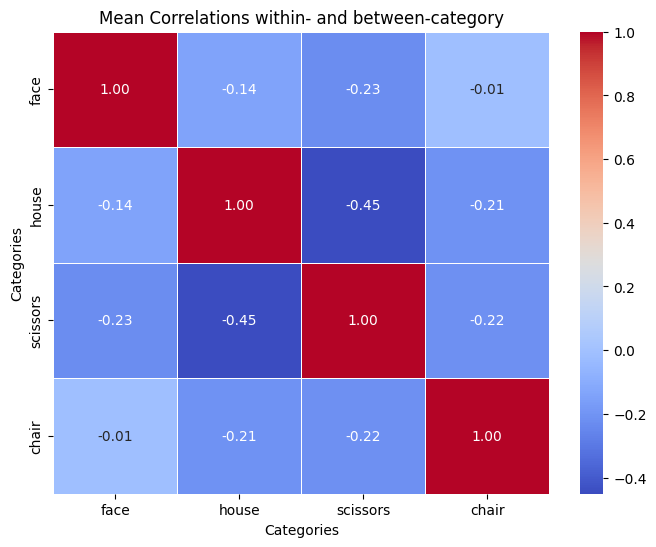

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check the data types of the DataFrame
print(correlations.dtypes)

# Convert the data type to float if needed
correlations = correlations.astype(float)
# Visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Mean Correlations within- and between-category")
plt.xlabel("Categories")
plt.ylabel("Categories")
plt.show()


In [49]:
# Initialize a DataFrame for storing RSA
rsa_df = pd.DataFrame(index=categories, columns=categories)

# Compute RSA
for category1 in categories:
    for category2 in categories:
        # Compute the cosine distance between the mean removed fMRI data for the two categories
        distance = pdist([mean_removed_fmri_dict[category1].mean(axis=0), mean_removed_fmri_dict[category2].mean(axis=0)], metric='cosine')

        # Since pdist returns a condensed distance matrix, we take the first element
        rsa_df.loc[category1, category2] = distance[0]

# printing RSA data
print( "\nRepresentational Similarity  Analysis (RSA) using Cosine distance:")
print(rsa_df)



Representational Similarity  Analysis (RSA) using Cosine distance:
              face     house  scissors     chair
face           0.0  1.157961  1.219649  1.015087
house     1.157961       0.0  1.408043  1.154559
scissors  1.219649  1.408043       0.0  1.217661
chair     1.015087  1.154559  1.217661       0.0


face        object
house       object
scissors    object
chair       object
dtype: object


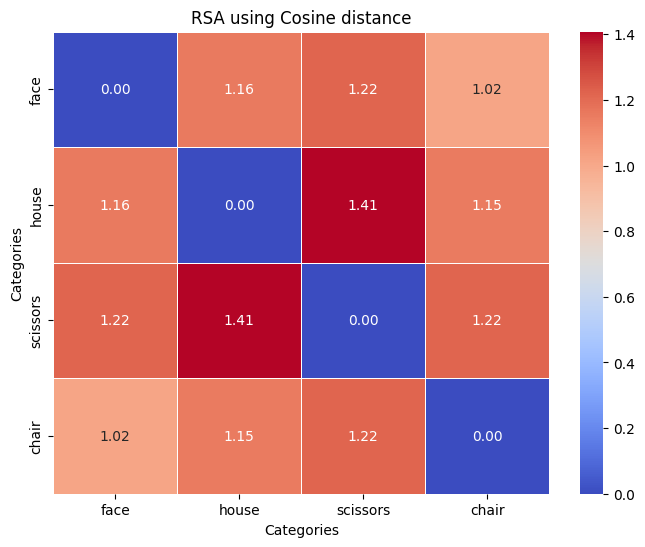

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check the data types of the DataFrame
print(rsa_df.dtypes)

# Convertint to float , it was in object form
rsa_df = rsa_df.astype(float)

# Visualize our RSA result
plt.figure(figsize=(8, 6))
sns.heatmap(rsa_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("RSA using Cosine distance")
plt.xlabel("Categories")
plt.ylabel("Categories")
plt.show()
